# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
#conda create -n gnn_amazon python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [2]:
pip list

Package                   Version
------------------------- --------------
anyio                     4.4.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
attrs                     24.2.0
backcall                  0.2.0
beautifulsoup4            4.12.3
bleach                    6.1.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.7.4
cffi                      1.17.0
chardet                   4.0.0
comm                      0.2.2
cycler                    0.12.1
debugpy                   1.8.5
decorator                 5.1.1
defusedxml                0.7.1
Deprecated                1.2.14
dgl                       0.5.3
dimod                     0.12.16
dwave-neal                0.6.0
dwave-samplers            1.3.0
entrypoints               0.4
exceptiongroup            1.2.2
executing                 2.1.0
fastjsonschema            2.20.0
fqdn              

In [3]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from pyqubo import Binary #For QUBO
from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation import maximum_independent_set as mis
from time import time

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using backend: pytorch


In [4]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [5]:
from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

### Problem-specific (MIS) utilities

In [6]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

In [7]:
data = [(0, 1, 0.0146),
 (0, 2, 0.2253),
 (0, 4, 0.0907),
 (1, 3, 0.1356),
 (1, 5, 0.205),
 (2, 8, 0.1271),
 (2, 23, 0.084),
 (3, 8, 0.111),
 (4, 9, 0.094),
 (5, 9, 0.0642),
 (6, 7, 0.0652),
 (7, 8, 0.1762),
 (7, 9, 0.1762),
 (8, 10, 0.084),
 (8, 11, 0.084),
 (9, 10, 0.084),
 (9, 11, 0.084),
 (10, 12, 0.0488),
 (10, 13, 0.0426),
 (11, 12, 0.0488),
 (11, 22, 0.0985),
 (12, 22, 0.0884),
 (13, 15, 0.0594),
 (14, 15, 0.0172),
 (14, 20, 0.0249),
 (14, 23, 0.0529),
 (15, 16, 0.0263),
 (15, 18, 0.0234),
 (16, 17, 0.0143),
 (16, 21, 0.1069),
 (17, 20, 0.0132),
 (18, 19, 0.0203),
 (19, 22, 0.0112),
 (20, 21, 0.0692)]

# Create a graph object
G = nx.Graph()

# Add edges to the graph
G.add_weighted_edges_from(data)

In [8]:
def transform_dict_for_tensor(input_dict):
    """
    Transforms a dictionary with string tuple keys into a dictionary with integer tuple keys,
    suitable for creating a PyTorch 2D tensor.
    
    Parameters:
        input_dict (defaultdict): A dictionary with tuple keys of strings and numeric values.

    Returns:
        transformed_dict (dict): A dictionary with tuple keys of integers and the same values.
        node_to_idx (dict): A mapping from the original string labels to integer indices.
    """
    # Step 1: Create a sorted list of unique nodes in the order of "x0", "x1", ..., "xn"
    nodes = sorted(set(chain.from_iterable(input_dict.keys())), key=lambda x: int(x[1:]))
    
    # Step 2: Map each node (string) to a unique integer index
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    
    # Step 3: Transform the original dictionary into a dictionary with integer indices
    transformed_dict = defaultdict(int)
    for (x_coord, y_coord), val in input_dict.items():
        i = node_to_idx[x_coord]
        j = node_to_idx[y_coord]
        transformed_dict[(i, j)] = val
    
    return transformed_dict, node_to_idx


# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_maxcut(nx_G):
    """
    Helper function to generate QUBO matrix for MAXCUT as maximization problem.
    
    Input:
        nx_G: graph as networkx graph object
    Output:
        Q_dic: QUBO as defaultdict
    """
    
    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    #Initiate the Hamiltonian
    H = 0.0
    # Iterate over edges and their weights
    for u, v, data in nx_G.edges(data=True):
        
        #Define the binary for each i, j pair
        xi, xj = Binary(f"x{u}"), Binary(f"x{v}")

        #For weighted graphs
        if data:
            weight = data['weight']
            H += -weight*(xi + xj - 2*xi*xj)

        #For unweighted graps
        if not data:
            H += -(xi + xj - 2*xi*xj)

    H_compiled = H.compile().to_qubo()
    H_qubo = H_compiled[0]
    Q_dic.update(H_qubo)

    transformed_dict, node_to_idx = transform_dict_for_tensor(Q_dic)
    return transformed_dict

#gen_q_dict_maxcut(G)

# Step 1 - Set hyperparameters

In [10]:
# Graph hypers
n = 100
d = 3
p = 0.5
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 2 - Generate random graph

In [11]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value, weighted=True, weight_range=(0, 1))
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_maxcut(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=100, d=3, seed=1
Assigning random weights to edges in range (0, 1)


In [12]:
gen_q_dict_maxcut(nx_graph)

defaultdict(int,
            {(87, 87): -0.5371441156276566,
             (85, 31): 1.406764177207672,
             (51, 51): -1.3464355442015532,
             (34, 33): 1.1863674607601151,
             (65, 65): -1.5796997153685628,
             (51, 89): 0.7135799290899114,
             (68, 26): 1.097597522776306,
             (68, 68): -2.197258424672103,
             (24, 24): -1.123463222122722,
             (79, 78): 0.9475420283405578,
             (84, 55): 0.9162936001994488,
             (57, 57): -0.991277160994048,
             (66, 62): 0.16646827560779576,
             (40, 39): 1.904934776536539,
             (76, 12): 0.46616890051514526,
             (8, 8): -1.5060074965654682,
             (11, 10): 0.8442331511654346,
             (59, 30): 0.9793870409245164,
             (54, 54): -0.9986081593905279,
             (95, 78): 0.04726915526397413,
             (53, 36): 1.7205795578410992,
             (22, 21): 1.340611132828142,
             (3, 3): -0.57169812808

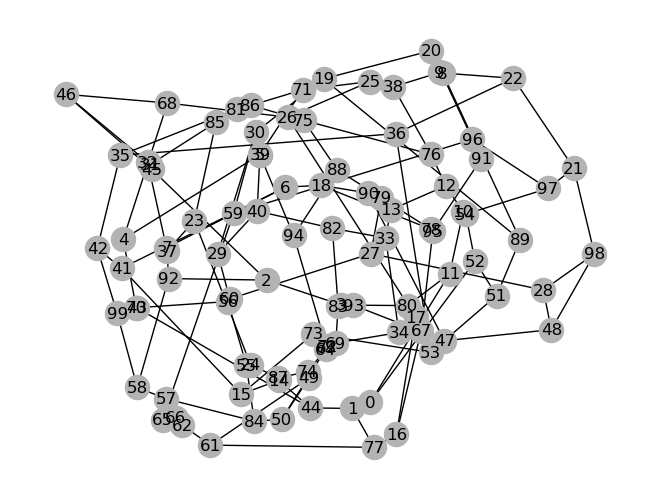

In [13]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [14]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

# Step 4 - Run GNN training

In [15]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -1.2219786643981934
Epoch: 1000, Loss: -11.935651779174805
Epoch: 2000, Loss: -37.35503005981445
Epoch: 3000, Loss: -52.6689567565918
Epoch: 4000, Loss: -59.2906379699707
Epoch: 5000, Loss: -62.436561584472656
Epoch: 6000, Loss: -63.69519805908203
Epoch: 7000, Loss: -64.22584533691406
Epoch: 8000, Loss: -64.48143005371094
Epoch: 9000, Loss: -64.6092529296875
Stopping early on epoch 9173 (patience: 100)
GNN training (n=100) took 32.87
GNN final continuous loss: -64.62379455566406
GNN best continuous loss: -64.62379455566406


# Step 5 - Post-process GNN results

In [16]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 50 with 10 violations
Took 32.89s, model training took 32.871s


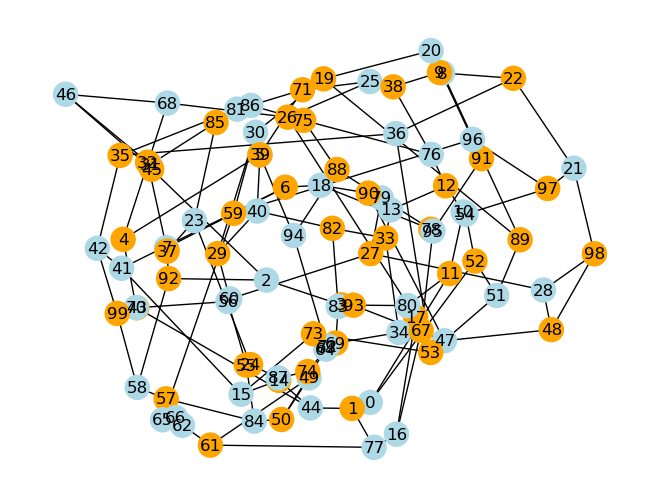

In [17]:
# Visualize result
# Note no light-blue nodes are connected by an edge
#print(best_bitstring)
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [18]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 36 with 0 violations.
MIS solver took 0.408s
